<a href="https://colab.research.google.com/github/ikabrain/UCS761-Deep-Learning-Lab/blob/main/DL_assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Assignment 2 - Logistic regression: Implement single layer perceptron for glass classification.](https://medium.com/analytics-vidhya/logistic-regression-using-single-layer-perceptron-neural-network-slpnn-31757c792d5d)

---


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(42)

## Import dataset

---

Link for dataset: https://www.kaggle.com/datasets/uciml/glass

In [3]:
import kagglehub

path = kagglehub.dataset_download("uciml/glass")

Using Colab cache for faster access to the 'glass' dataset.


In [4]:
df = pd.read_csv(path + "/glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [6]:
df["Type"].unique()

array([1, 2, 3, 5, 6, 7])

### Encoding target

In [7]:
df_encoded = pd.get_dummies(df, columns=["Type"], dtype=float)
df_encoded.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type_1,Type_2,Type_3,Type_5,Type_6,Type_7
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Analyzing Predictors


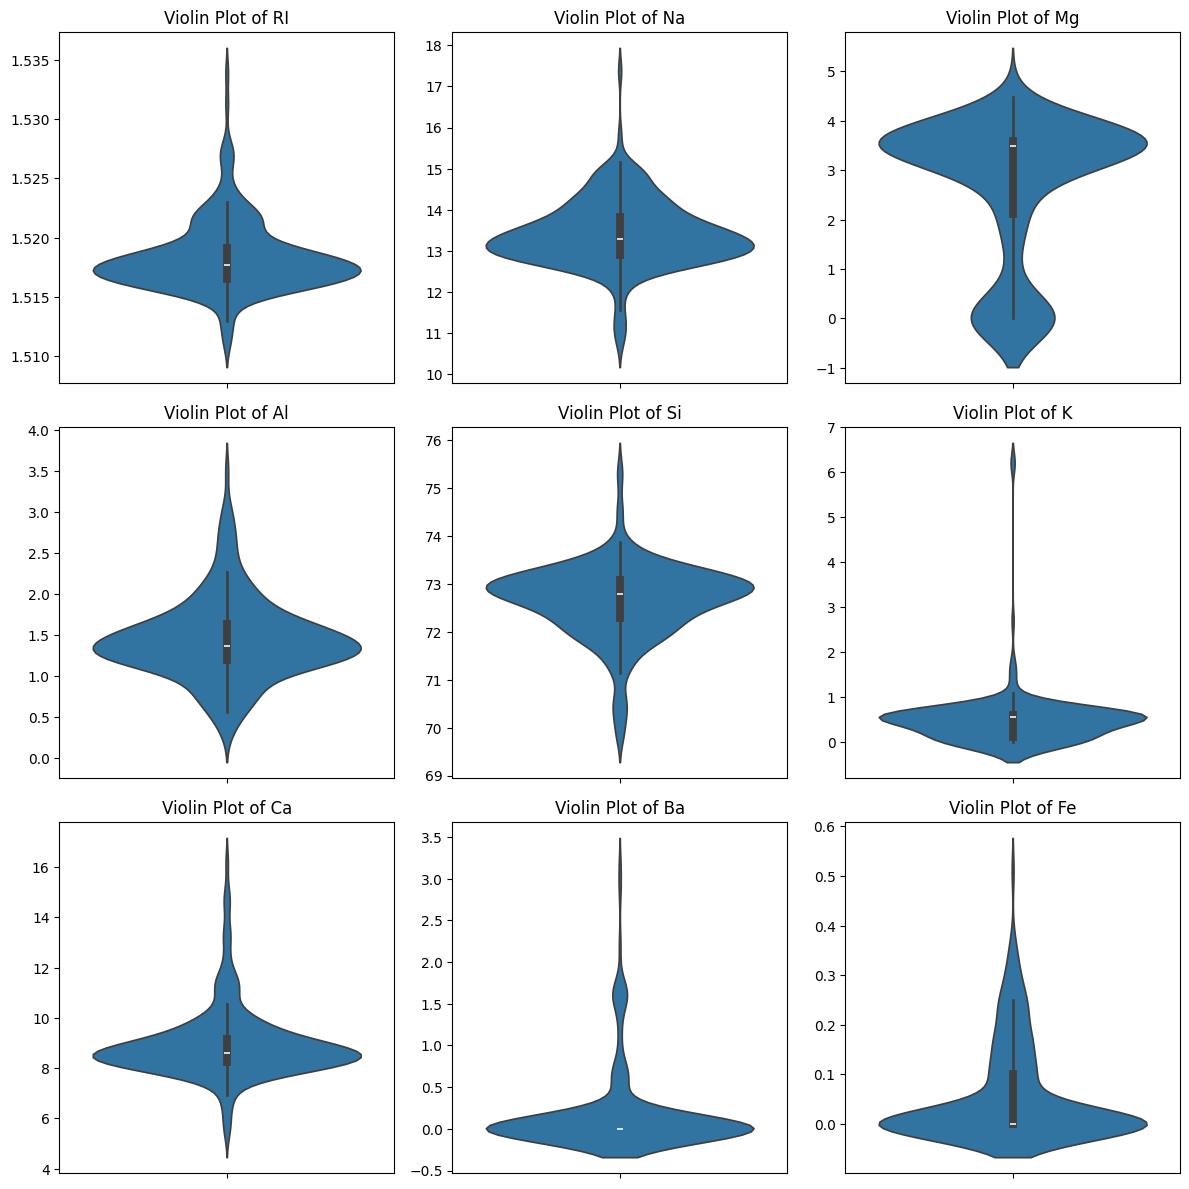

In [8]:
predictor_features = df.drop(columns='Type').columns
n_features = len(predictor_features)

n_cols = 3  # Number of columns for subplots
n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, feature in enumerate(predictor_features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.violinplot(y=df[feature])
    plt.title(f'Violin Plot of {feature}')
    plt.ylabel('') # Remove y-axis label to avoid clutter

plt.tight_layout()
plt.show()

### Splitting & scaling data

In [9]:
y = df_encoded.filter(regex="^Type_")
X = df_encoded.drop(columns=y.columns)
X = X.to_numpy()
y = y.to_numpy()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print(
    f"Training data: {X_train.shape[0]}\n"
    f"Testing data: {X_test.shape[0]}\n"
)

Training data: 171
Testing data: 43



In [11]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Designing single-layer logistic perceptron from scratch

---


We have

$$
    \text{Predictor} \quad X = \begin{bmatrix}
    x_{11} & x_{12} & \cdots & x_{1k} \\\\
    x_{21} & x_{22} & \cdots & x_{2k} \\\\
    \vdots & \vdots & \ddots & \vdots \\\\
    x_{n1} & x_{n2} & ... & x_{nk} \\\\
    \end{bmatrix}_{n \times k}
    = \begin{pmatrix}
    X_{1} & X_{2} & X_{3} & \cdots & X_{n}
    \end{pmatrix}^{T}
$$

$$
    \text{Target (per class)} \quad y_{class=\{1,2,3,5,6,7\}}^{(class)} = \begin{bmatrix}
    y_{1}^{(class)} \\\\
    y_{2}^{(class)} \\\\
    \vdots \\\\
    y_{n}^{(class)} \\\\
    \end{bmatrix}_{n \times 1}
    = \begin{pmatrix}
    y_{1}^{(class)} & y_{2}^{(class)} & y_{3}^{(class)} & \cdots & y_{n}^{(class)}
    \end{pmatrix}^{T}
$$

$$
    \Rightarrow \text{Weights (per class)} \quad \beta_{k \times 1}^{(class)} =
    \begin{pmatrix}
    \beta_1^{(class)} & \beta_2^{(class)} & \beta_3^{(class)} & \cdots & \beta_k^{(class)}
    \end{pmatrix}^{T}
$$

$$
    \text{& Bias (per class)} = \beta_{0}^{(class)}
$$

Calculating logits,

$$
    \text{Logit (per class)} \quad z^{(class)}_{n\times1} = X\beta^{(class)} + \epsilon_{n\times1}
$$

$$
    \Rightarrow
    z^{(class)} \approx \hat{z}^{(class)} = X\hat{\beta}^{(class)} + \hat{\beta}_{0}^{(class)}
$$

For binary classification, we have

$$
    \text{Probability} \quad \hat{y_i} = Sigmoid(\hat{z_i}) = \frac{1}{1 + e^{-\hat{z_i}}}
$$

In multi-class classification, sigmoid treats each class independently, so the model fails to automatically "push down" the probabilities of incorrect classes when the correct class probability rises, leading to **poor convergence** for mutually exclusive data.
<br>
(_The Whac-a-mole effect_: Model fixes one class, but the others are still wrong, so the model zig-zags (oscillates) instead of going straight to the answer)

So, for multi-class classification, we use **SOFTMAX** during training.

Softmax normalizes the raw outputs into a probability distribution that sums to 1, **forcing the classes to compete** so the model can identify the single most likely category.

$$
    \text{Thus, Probability} \quad \hat{y_i}^{(class)} = softmax(\hat{z_i}^{(class)}) = \frac{e^{\hat{z_i}^{(class)}}}{\sum_{j=1}^K e^{\hat{z_j}^{(class)}}}
$$
_(Here, the $\Sigma$ is across the ROWS of the matrix $z_{n\times1}$)_

Now, we use CATEGORICAL cross-entropy for multi-class classification

$$
    \mathcal{L}(y_{i}, \hat{y}_i) = -\frac{1}{n}\sum_{j=1}^{c}y_{ij}log_e(\hat{y}_{ij})
$$

So, total cross-entropy loss is
$$
    \mathcal{L}(y, \hat{y}) = -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{c}y_{ij}log_e(\hat{y}_{ij})
$$

Taking derivative, we get
$$
    \frac{\partial\mathcal{L}}{\partial\beta_{j}^{(class)}}(y_{i}, \hat{y}_i) =
    (\hat{y}_i - y_{i})*X_{i}
$$

In [12]:
class LogisticPerceptron:
    def __init__(self, lr=0.1, n_iter=1000):
        self.lr = lr
        self.epochs = n_iter
        self.weights = None
        self.bias = None
        self.trained = False

    def _initialize_weights(self, n_features, n_classes):
        self.weights = np.random.randn(n_features, n_classes)
        self.bias = np.random.randn(n_classes)
        return self.weights, self.bias

    def _get_logit(self, X, weights, bias):
        return np.dot(X, weights) + bias

    def _softmax(self, z):
        """Softmax activation function"""
        exp_z = np.exp(z - np.max(z)) # Subtract the maximum value from each element for numerical stability
        return exp_z / exp_z.sum(axis=0)

    def predict(self, X):
        """
        One forward pass with samples in X
        """
        z = self._get_logit(X, self.weights, self.bias)
        # Handle 1D (single sample) vs 2D (batch) arrays
        if z.ndim == 1:
            return self._softmax(z)
        # For batch, apply softmax row-wise
        return np.array([self._softmax(sample) for sample in z])

    def _categorical_loss(self, y_true, y_pred):
        """Return the Categorical Entropy Loss between y_true and y_pred"""
        # Ensure probabilities are clipped to avoid log(0) which results in infinity or NaN
        # A small epsilon value (1e-15) is added/subtracted for numerical stability
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
        return -np.sum(y_true * np.log(y_pred))

    def _update_weights(self, input, error_val):
        """Updates weights of the Logistic Perceptron using the PERCEPTRON ALGORITHM, NOT GRADIENT DESCENT"""
        self.weights += self.lr * np.outer(input, error_val) # Gets the product in appropriate dimensions & converts to scalar
        self.bias += self.lr * error_val
        return (self.weights, self.bias)

    def fit(self, X, y):
        # 1. Initialize weights and bias
        n_samples, n_feat = X.shape
        n_classes = y.shape[1]
        self._initialize_weights(n_feat, n_classes)

        for epoch in range(self.epochs):
            for sample_idx, sample in enumerate(X):
                # 2. Calculate linear output & 3. Apply activation function
                y_pred = self.predict(sample)

                # 4. Update weights and bias using perceptron algorithm
                error = y[sample_idx] - y_pred
                self._update_weights(sample, error)

            if epoch % 100 == 0:
                full_predictions = self.predict(X)
                loss = self._categorical_loss(y, full_predictions)
                print(f"Epoch {epoch}/{self.epochs}: Loss = {loss:.4f}")

        self.trained = True
        return self

    def __repr__(self):
        return f"LogisticPerceptron(lr={self.lr}, n_iter={self.epochs}, trained={self.trained})"

## Using logistic perceptron on dataset

---

In [13]:
%%time
p = LogisticPerceptron(lr=0.1, n_iter=2000)
p.fit(X_train, y_train)

Epoch 0/2000: Loss = 212.4155
Epoch 100/2000: Loss = 110.7178
Epoch 200/2000: Loss = 105.6323
Epoch 300/2000: Loss = 103.4683
Epoch 400/2000: Loss = 102.2425
Epoch 500/2000: Loss = 101.4471
Epoch 600/2000: Loss = 100.8871
Epoch 700/2000: Loss = 100.4728
Epoch 800/2000: Loss = 100.1567
Epoch 900/2000: Loss = 99.9091
Epoch 1000/2000: Loss = 99.7104
Epoch 1100/2000: Loss = 99.5471
Epoch 1200/2000: Loss = 99.4101
Epoch 1300/2000: Loss = 99.2930
Epoch 1400/2000: Loss = 99.1912
Epoch 1500/2000: Loss = 99.1013
Epoch 1600/2000: Loss = 99.0208
Epoch 1700/2000: Loss = 98.9480
Epoch 1800/2000: Loss = 98.8814
Epoch 1900/2000: Loss = 98.8199
CPU times: user 9.51 s, sys: 140 ms, total: 9.65 s
Wall time: 14 s


LogisticPerceptron(lr=0.1, n_iter=2000, trained=True)

In [14]:
y_pred = p.predict(X_test)

acc = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 62.79%


In [15]:
# Testing on first row
print(f"Scaled values of first record: {X[0]}")
print(f"Actual target: {y[0].argmax()}")
print(f"Predicted target: {p.predict(X[0]).argmax()}")

Scaled values of first record: [1.52101e+00 1.36400e+01 4.49000e+00 1.10000e+00 7.17800e+01 6.00000e-02
 8.75000e+00 0.00000e+00 0.00000e+00]
Actual target: 0
Predicted target: 5
